# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os

In [2]:
os.getenv("PUIDATA")

'/home/cusp/cx495/PUIdata'

## Working with Shape File

### Loading Census Tract Shape File

In [3]:
from geopandas import GeoDataFrame
shape_path=os.getenv("PUIDATA") + "/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

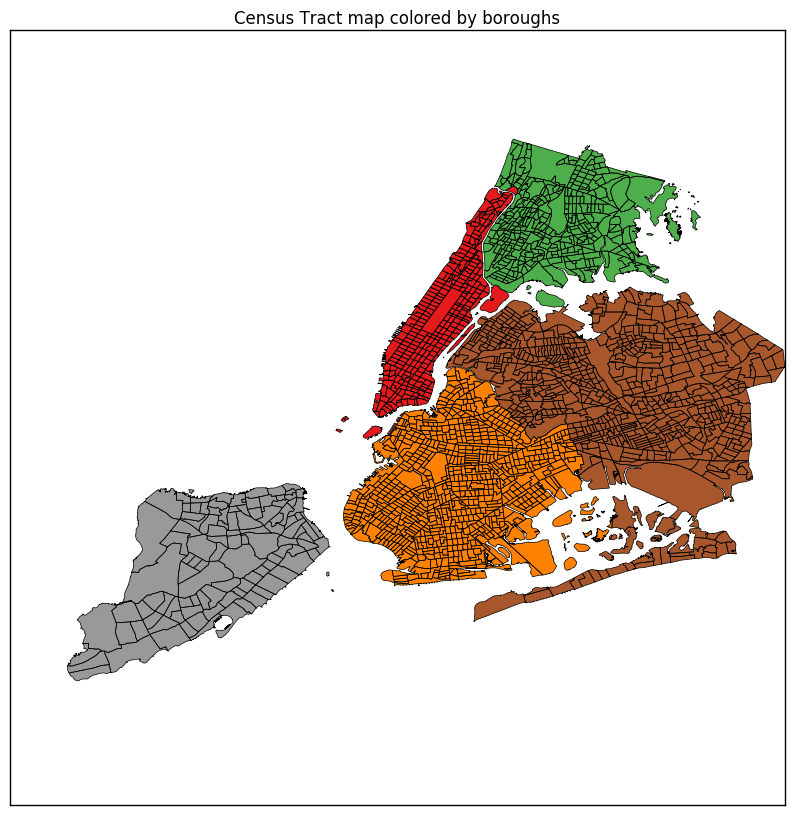

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Figure1: Census tract map by boroughs

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv(os.getenv("PUIDATA") + '/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


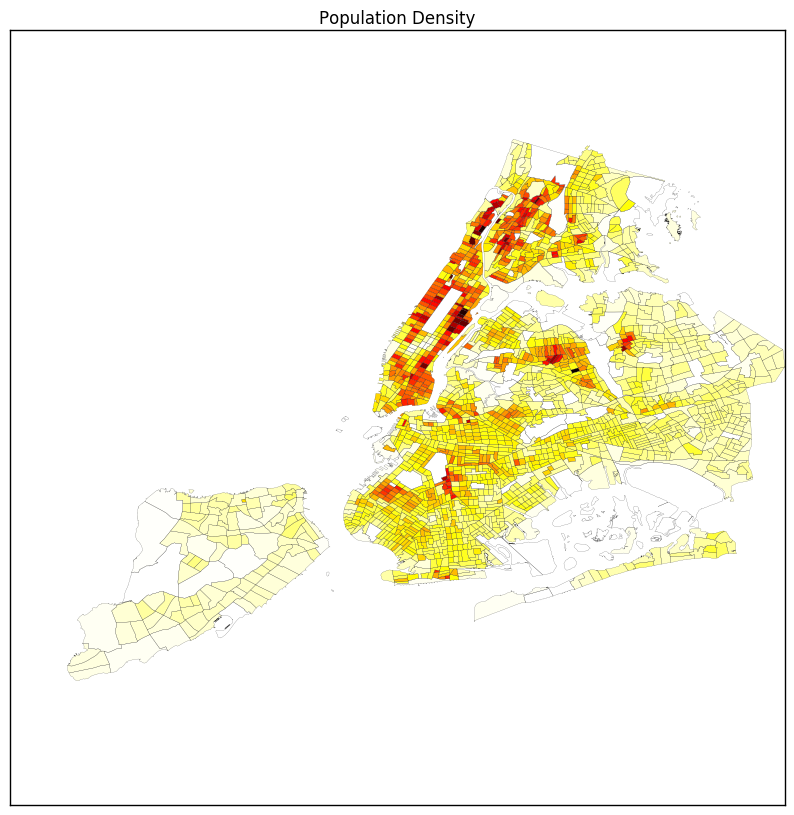

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

### Figure2: Population density of New York City

## Explore CitiBike data

### Load CitiBike data

In [10]:
df_bike_monthly=DataFrame.from_csv(os.getenv("PUIDATA") + '/CitiBike_monthly_byStation.csv')
df_bike_monthly.head(12)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# choose June, July and August as Summer and choose November, December and January as Winter
summer_mask = np.in1d(df_bike_monthly.index.month, [6,7,8])
winter_mask = np.in1d(df_bike_monthly.index.month, [11,12,1])

In [15]:
df_bike_summer = df_bike_monthly.copy()
df_bike_summer = df_bike_summer[summer_mask]
df_bike_winter = df_bike_monthly.copy()
df_bike_winter = df_bike_winter[winter_mask]

### Time Series Aanalysis

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


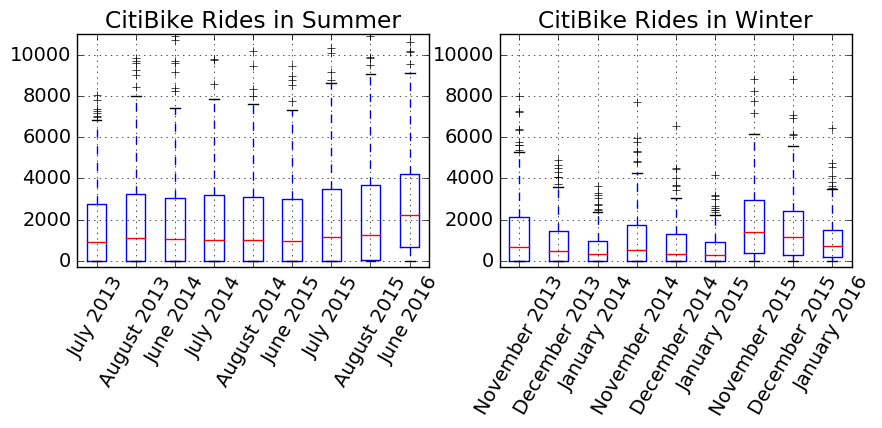

In [25]:
plt.rcParams['font.size']=14
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,3))

df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(5,5),ax=ax1,rot=60);
ax1.set_ylim([-300,11000])


df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7),ax=ax2,rot=60);
ax2.set_ylim([-300,11000])

ax1.set_title("CitiBike Rides in Summer")
ax2.set_title("CitiBike Rides in Winter")

### Figure3: Time series analysis of CitiBike rides in Summer and Winter

#### Seasonal Decomposition

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


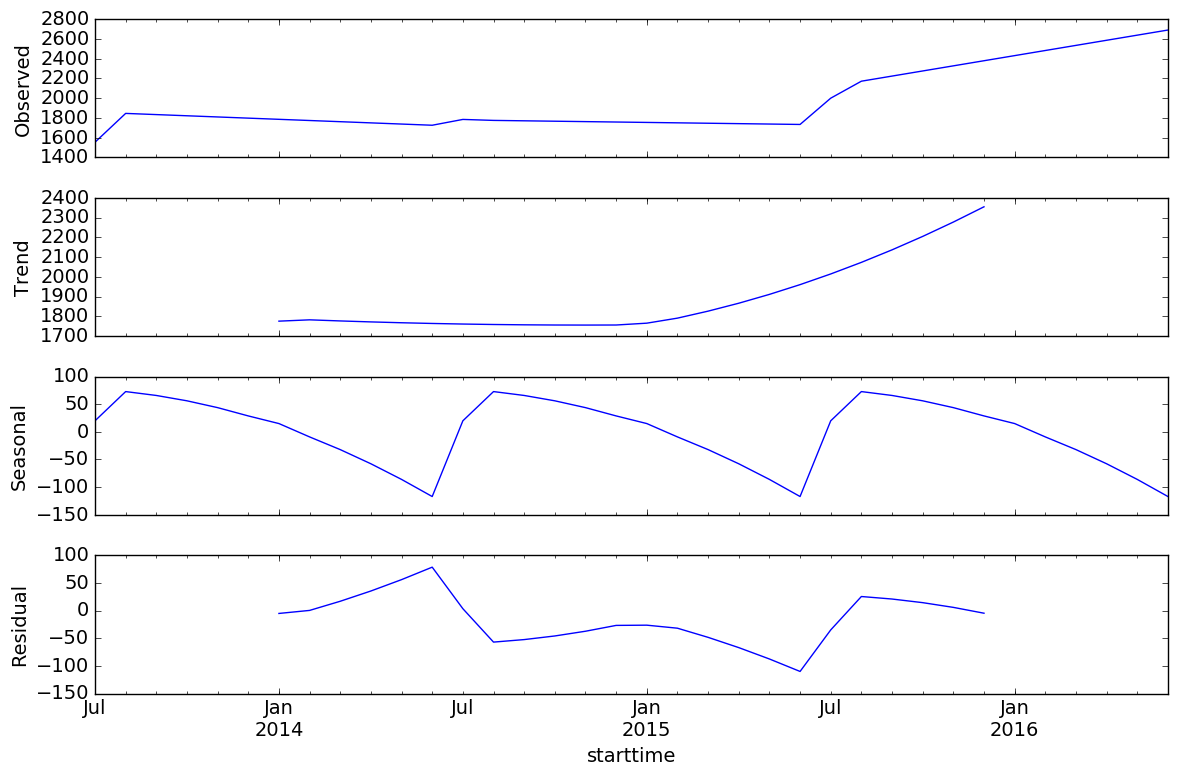

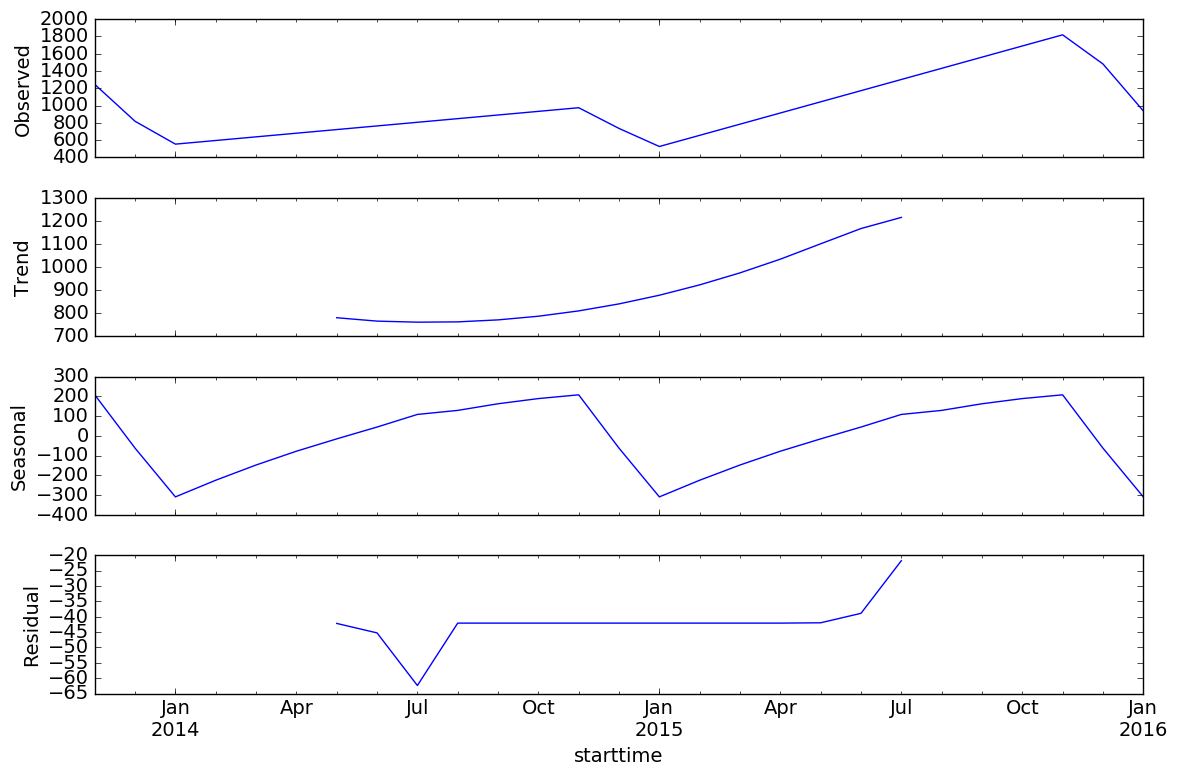

In [26]:
import statsmodels.api as sm

df_new=df_bike_summer.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

df_new=df_bike_winter.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

### Figure4: Seasonal decomposition of CitiBike rides in Summer and Winter

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [27]:
station_id=DataFrame.from_csv(os.getenv("PUIDATA") + '/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [28]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [29]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [30]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [31]:
station_id['SummerAve']=df_bike_summer.sum()
station_id['WinterAve']=df_bike_winter.sum()

In [32]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,12622
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,16148
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,47754
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,18568
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,30739


### Add the monthly average rides to the CT shapefile 

In [36]:
# use the 
temp = station_id[['SummerAve','WinterAve']]

temp.index=station_id['BoroCT2010']
temp['station_id']=station_id.index

ct_shape_SummerAve=ct_shape.join(temp)
ct_shape_SummerAve.fillna(0,inplace=True)

ct_shape_WinterAve=ct_shape.join(temp)
ct_shape_WinterAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


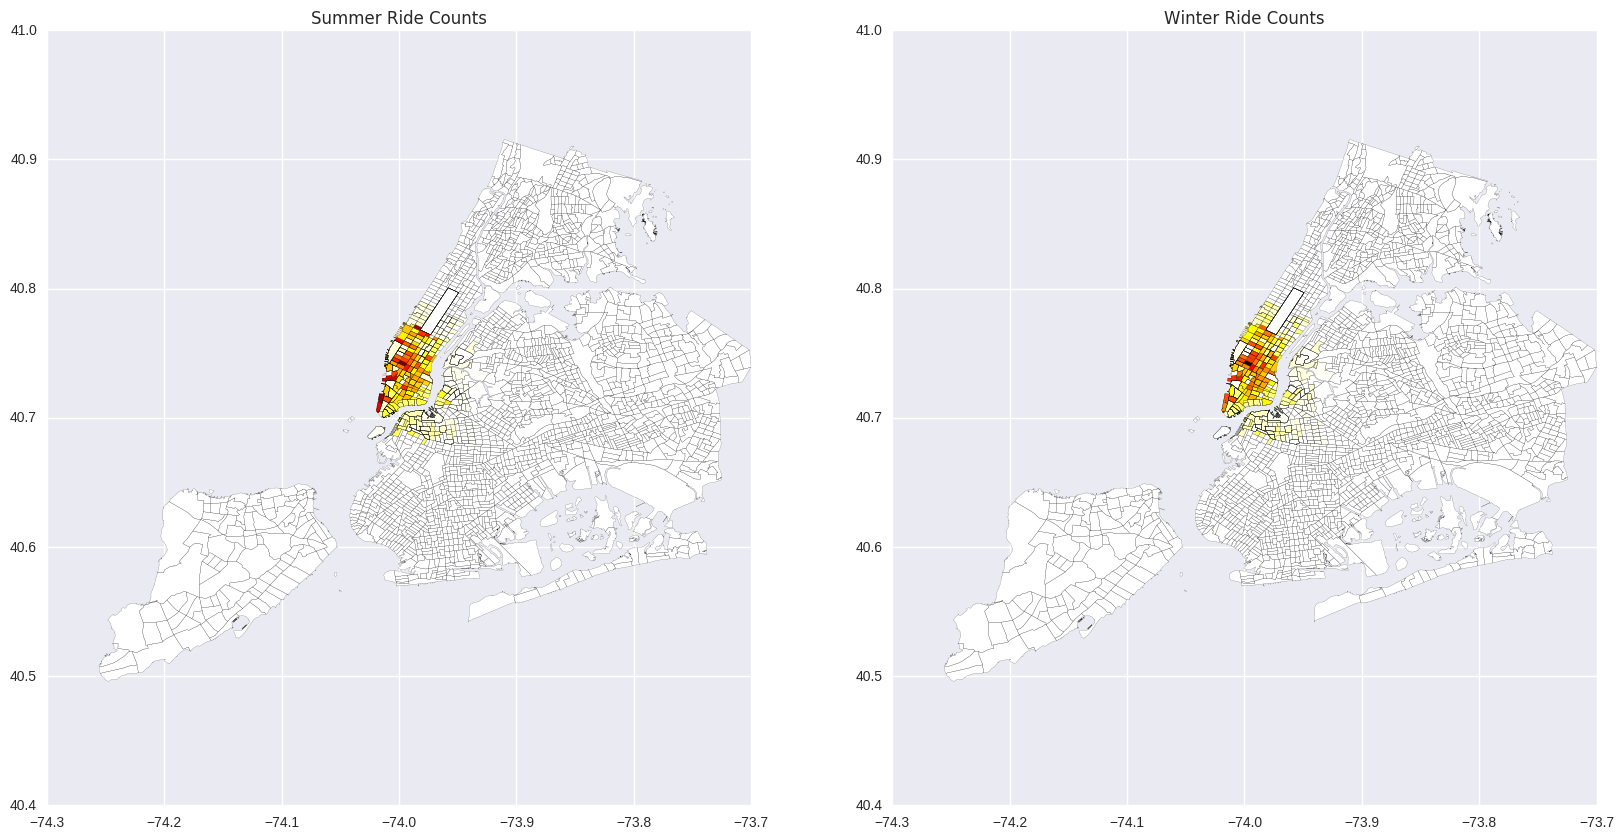

In [118]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ct_shape_SummerAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Summer Ride Counts")
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Winter Ride Counts")

### Figure5: Summer ride counts and winter rides counts

### Removing the CTs that are out of zoom boundries

In [53]:
ct_shape_SummerAve_Zoom=(ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])
ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [54]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed Summer CTs:", len(temp.SummerAve)
print "Number of zoomed Winter CTs:", len(temp.WinterAve)

Total number of CTs: 2166
Number of zoomed Summer CTs: 543
Number of zoomed Winter CTs: 543


### Map the monthly rides 

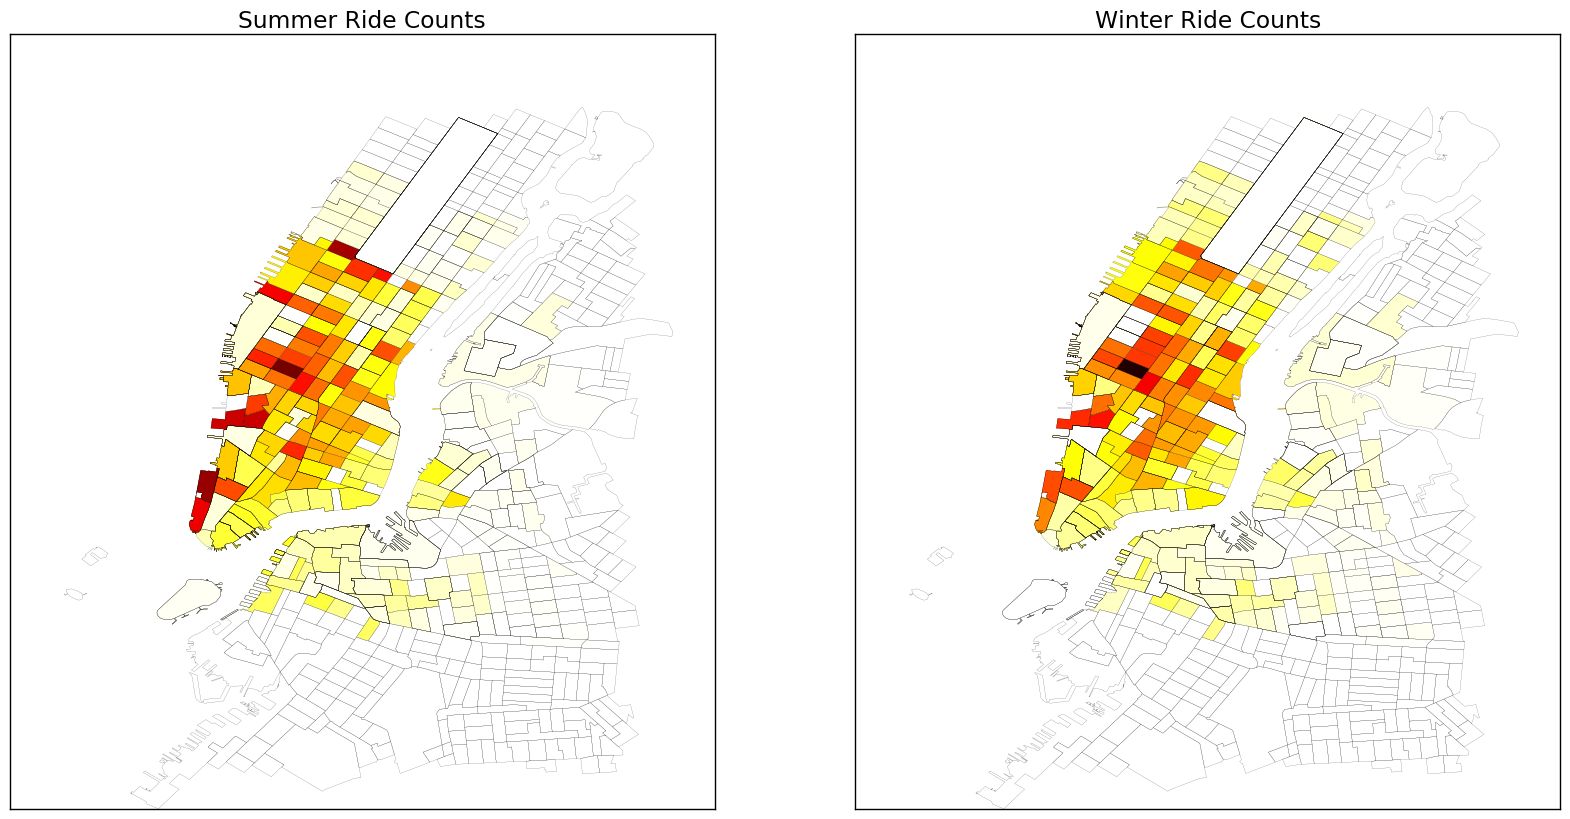

In [55]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Summer Ride Counts")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Winter Ride Counts")

### Figure6: Zommed summer ride counts and winter rides counts

### Export Shapefile CTs in the CitiBike Zone

In [56]:
path=os.getenv("PUIDATA") + '/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(path)
ct_shape_WinterAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [57]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [58]:
qW_CT=ps.queen_from_shapefile(path)

Island id:  [0]


In [59]:
ps.queen_from_shapefile?

#### Neighbors of index10

In [60]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [61]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [62]:
Wmatrix, ids = qW_CT.full()

In [63]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [64]:
qW_CT.transform = 'r'

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [65]:
SummerRide=ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

WinterRide=ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [67]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)

In [68]:
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [69]:
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    45.429                 2
   45.429 < x[i] <=   763.792                78
  763.792 < x[i] <=  1903.583                80
 1903.583 < x[i] <=  3025.970                79
 3025.970 < x[i] <=  4383.619                80
 4383.619 < x[i] <= 10166.268                79
10166.268 < x[i] <= 13938.130                80
13938.130 < x[i] <= 16783.186                79
16783.186 < x[i] <= 26923.429                80

#### Map the monthly rides lag

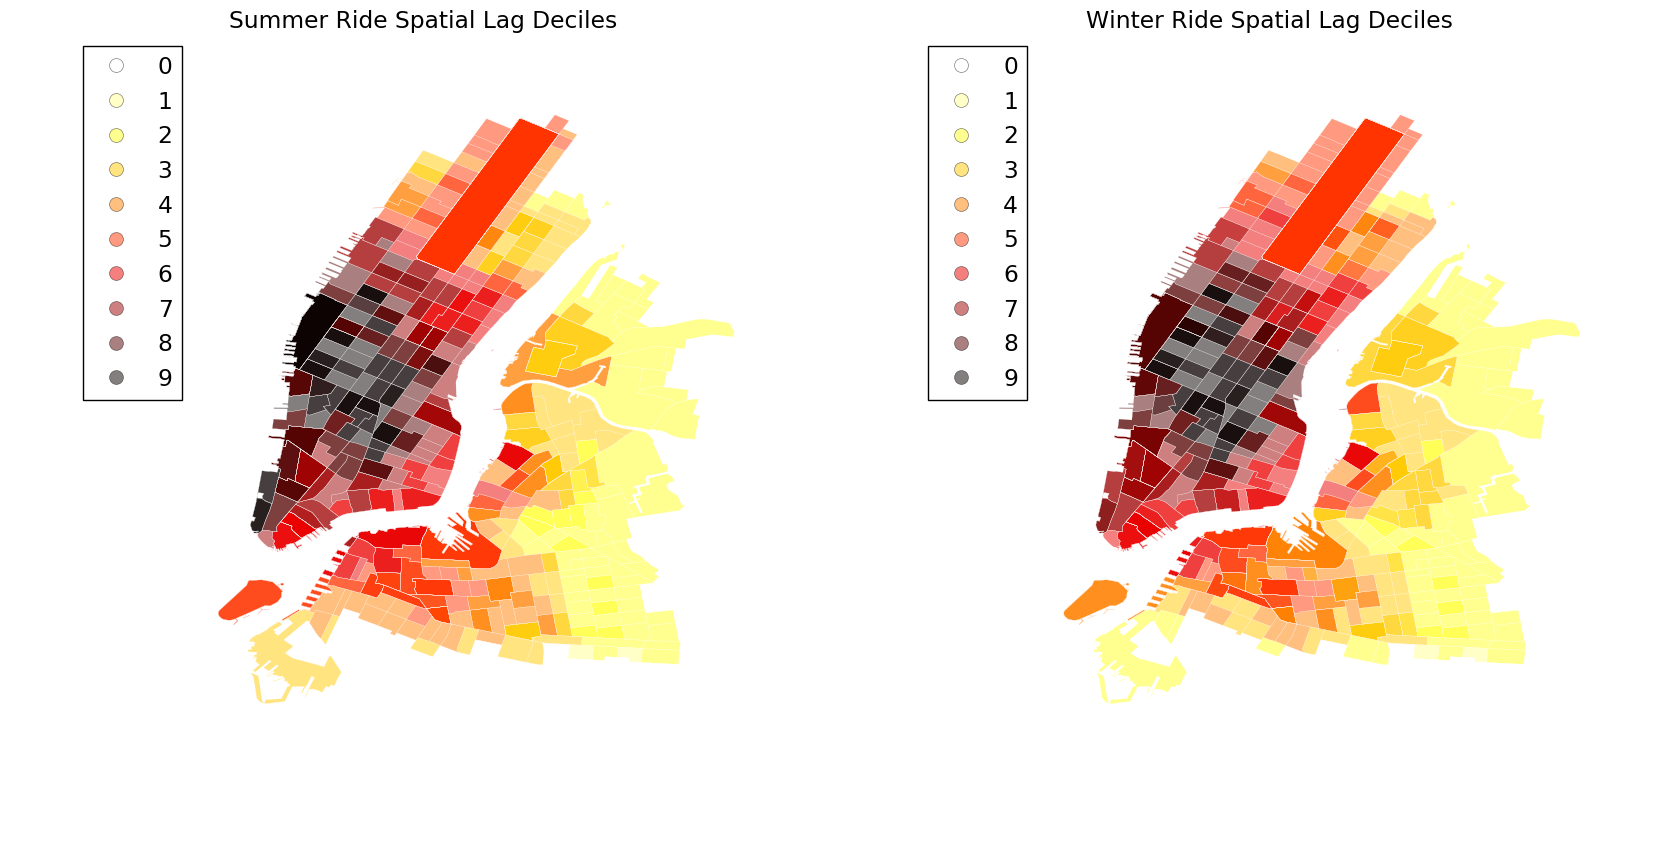

In [71]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))

ct_shape_SummerAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax1.set_title("Summer Ride Spatial Lag Deciles")

ct_shape_WinterAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("Winter Ride Spatial Lag Deciles")

### Figure7: Summer and winter ride spatial lag deciles

## Global  Spatial Autocorrelation

In [72]:
Summer_b,Summer_a = np.polyfit(SummerRide, SummerRideLag, 1)
Summer_b,Summer_a 

(0.64335490815356511, 4220.5552980795601)

In [73]:
Winter_b,Winter_a = np.polyfit(WinterRide, WinterRideLag, 1)
Winter_b,Winter_a 

(0.65791812867838495, 2135.438012377781)

### Moran Scatterplot

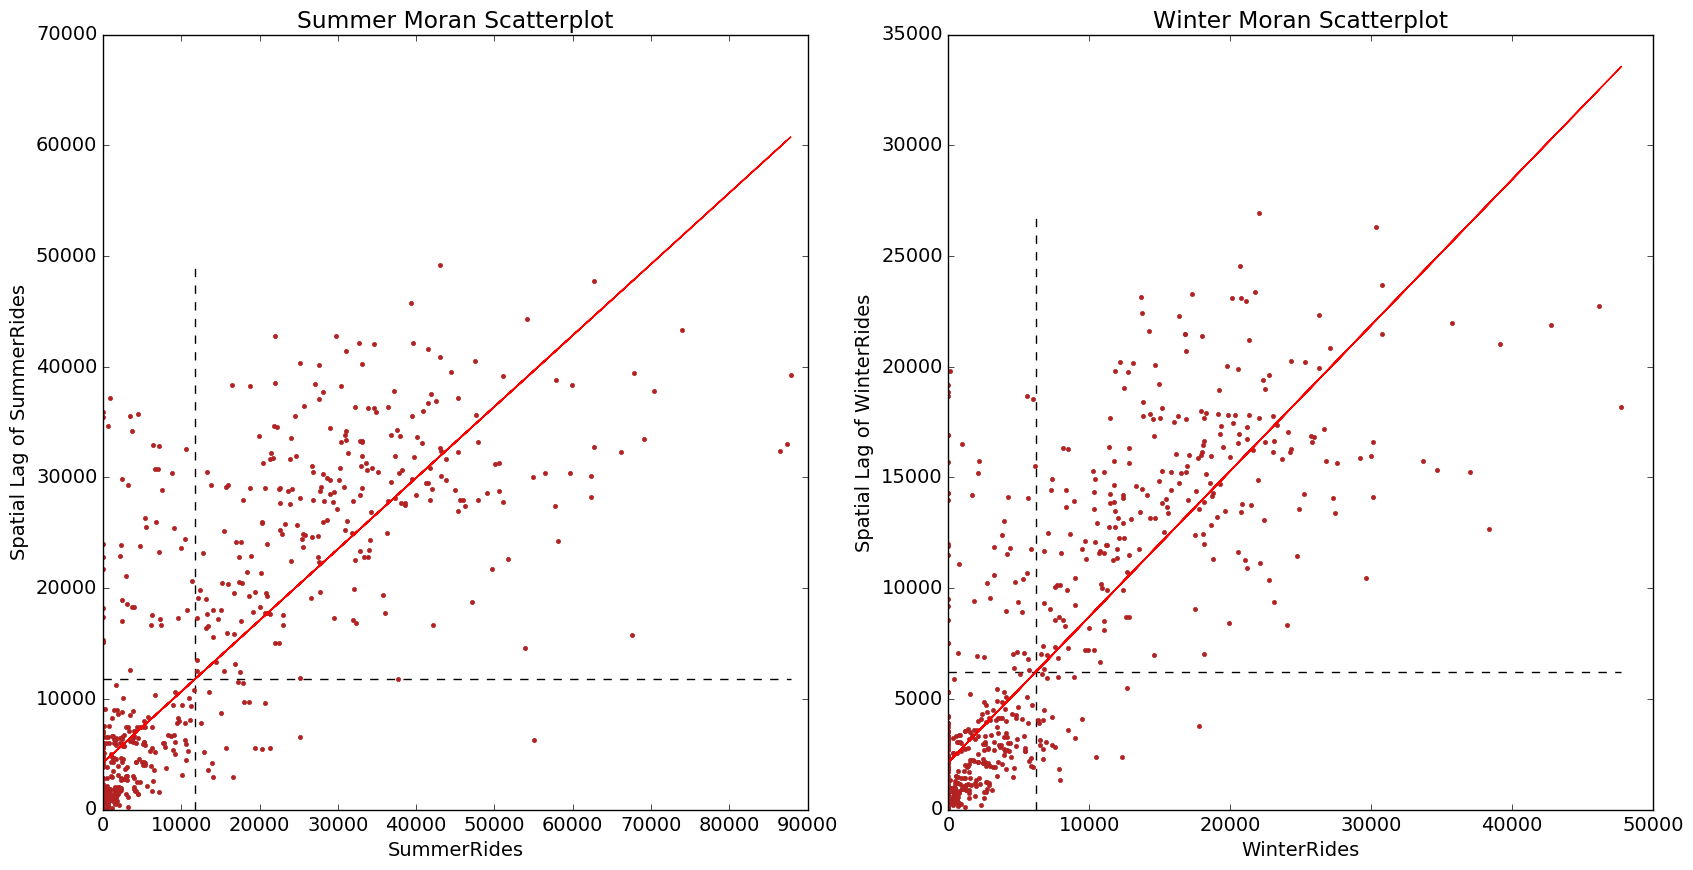

In [80]:
f, (ax1,ax2)= plt.subplots(1, 2, figsize=(20,10))

ax1.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(SummerRide, Summer_a + Summer_b*SummerRide, 'r')
ax1.set_title('Summer Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of SummerRides')
ax1.set_xlabel('SummerRides')

ax2.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax2.hlines(WinterRideLag.mean(), WinterRide.min(),WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax2.plot(WinterRide, Winter_a + Winter_b*WinterRide, 'r')
ax2.set_title('Winter Moran Scatterplot')
ax2.set_ylabel('Spatial Lag of WinterRides')
ax2.set_xlabel('WinterRides')

## Figure8 :Global ummer and winter moran scatterplots

### Moran's I

In [81]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [82]:
I_SummerRide.I, I_SummerRide.p_sim #sim p-value:how sigificant is this line

(0.64353398667011008, 0.001)

Thus, the $I$ statistic is $0.644$ for this data, and has a very small $p$ value. 

In [83]:
I_SummerRide.sim[0:10]

array([-0.01999077, -0.01374842, -0.02222898,  0.00861211,  0.00630992,
       -0.03278873,  0.03467761, -0.0050061 , -0.0038183 ,  0.01512706])

In [84]:
I_WinterRide.I, I_WinterRide.p_sim

(0.65807911213278847, 0.001)

Thus, the $I$ statistic is $0.658$ for this data, and has a very small $p$ value. 

In [86]:
I_WinterRide.sim[0:10]

array([ 0.00656433, -0.0112329 , -0.023656  ,  0.00921741, -0.01193319,
        0.01816997, -0.02482242, -0.01717703,  0.01747098, -0.01588917])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [93]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

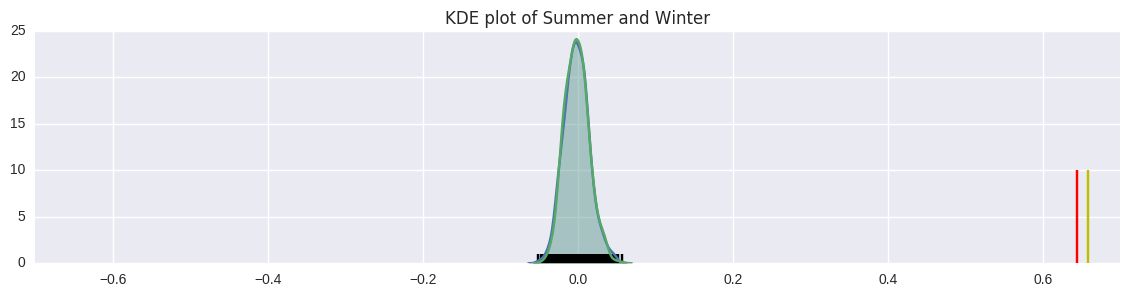

In [94]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'y')
plt.xlim([-.70, .70])

plt.title('KDE plot of Summer and Winter')

### Figure9:  KDE plotS

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

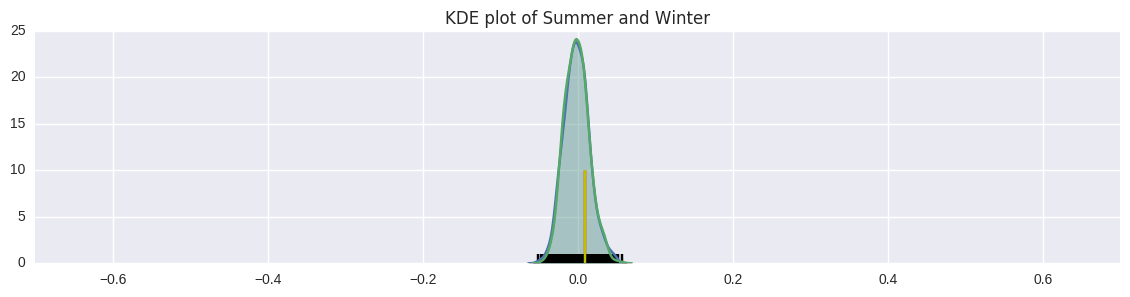

In [95]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'y')
plt.xlim([-.70, .70])

plt.title('KDE plot of Summer and Winter')

### Figure10: KDE plots_EI

## Local  Spatial Autocorrelation

In [96]:
SummerRide.shape

(796,)

In [97]:
LMo_SummerRide = ps.Moran_Local(np.array(SummerRide), qW_CT, permutations=999)

In [98]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.193,  0.334,  0.335,  0.359]))

In [99]:
WinterRide.shape

(796,)

In [100]:
LMo_WinterRide = ps.Moran_Local(np.array(WinterRide), qW_CT, permutations=999)

In [101]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.28144544,  0.00132628, -0.00265961, -0.06467646]),
 array([ 0.001,  0.155,  0.485,  0.5  ,  0.413]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [102]:
Summer_sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
Summer_W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
Summer_insigs = SummerRide[LMo_SummerRide.p_sim > .001]
Summer_W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

In [103]:
Winter_sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
Winter_W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
Winter_insigs = WinterRide[LMo_WinterRide.p_sim > .001]
Winter_W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

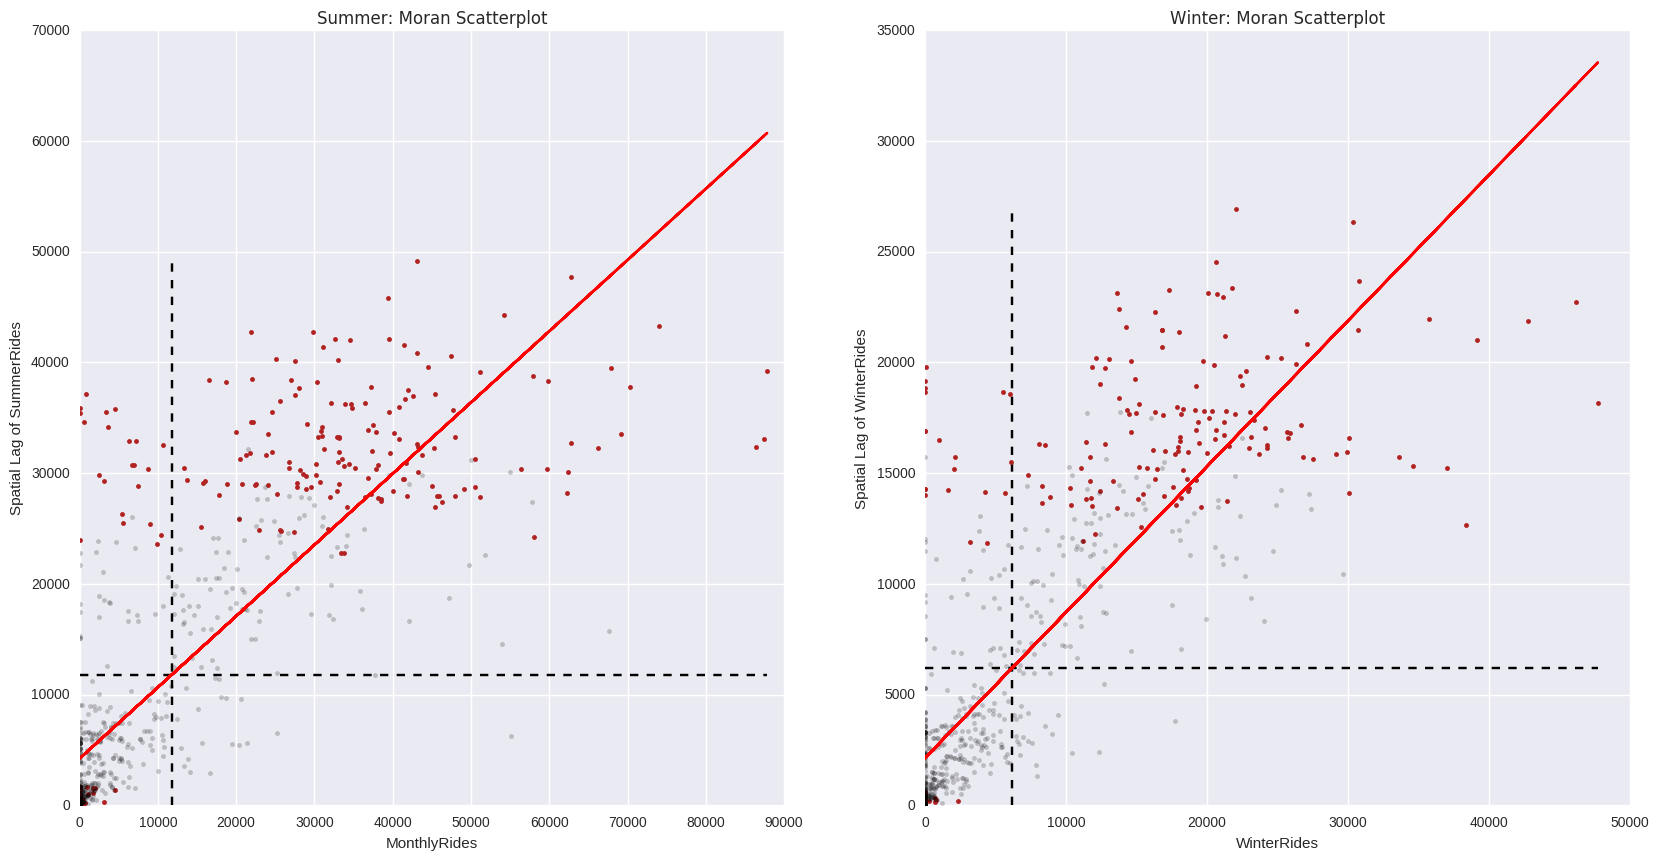

In [105]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(Summer_sigs, Summer_W_sigs, '.', color='firebrick')
ax1.plot(Summer_insigs, Summer_W_insigs, '.k', alpha=.2)
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')
ax1.plot(SummerRide, Summer_a + Summer_b*SummerRide, 'r')
ax1.set_title('Summer: Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of SummerRides')
ax1.set_xlabel('MonthlyRides')

ax2.plot(Winter_sigs, Winter_W_sigs, '.', color='firebrick')
ax2.plot(Winter_insigs, Winter_W_insigs, '.k', alpha=.2)
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')
ax2.plot(WinterRide, Winter_a + Winter_b*WinterRide, 'r')
ax2.set_title('Winter: Moran Scatterplot')
ax2.set_ylabel('Spatial Lag of WinterRides')
ax2.set_xlabel('WinterRides')

### Figure11: Global ummer and winter moran scatterplots

### Hot and Cold spots 

In [108]:
Summer_sig = LMo_SummerRide.p_sim < 0.01
Summer_hotspots = LMo_SummerRide.q==1 * Summer_sig
Summer_coldspots = LMo_SummerRide.q==3 * Summer_sig
print "Number of Hotspots in Summer:", Summer_hotspots.sum()
print "Number of Coldspots in Summer:", Summer_coldspots.sum()

 Number of Hotspots in Summer: 190
Number of Coldspots in Summer: 241


In [110]:
Winter_sig = LMo_WinterRide.p_sim < 0.01
Winter_hotspots = LMo_WinterRide.q==1 * Winter_sig
Winter_coldspots = LMo_WinterRide.q==3 * Winter_sig
print "Number of Hotspots in Winter:", Winter_hotspots.sum()
print "Number of Coldspots in Winter:", Winter_coldspots.sum()

 Number of Hotspots in Winter: 192
Number of Coldspots in Winter: 205


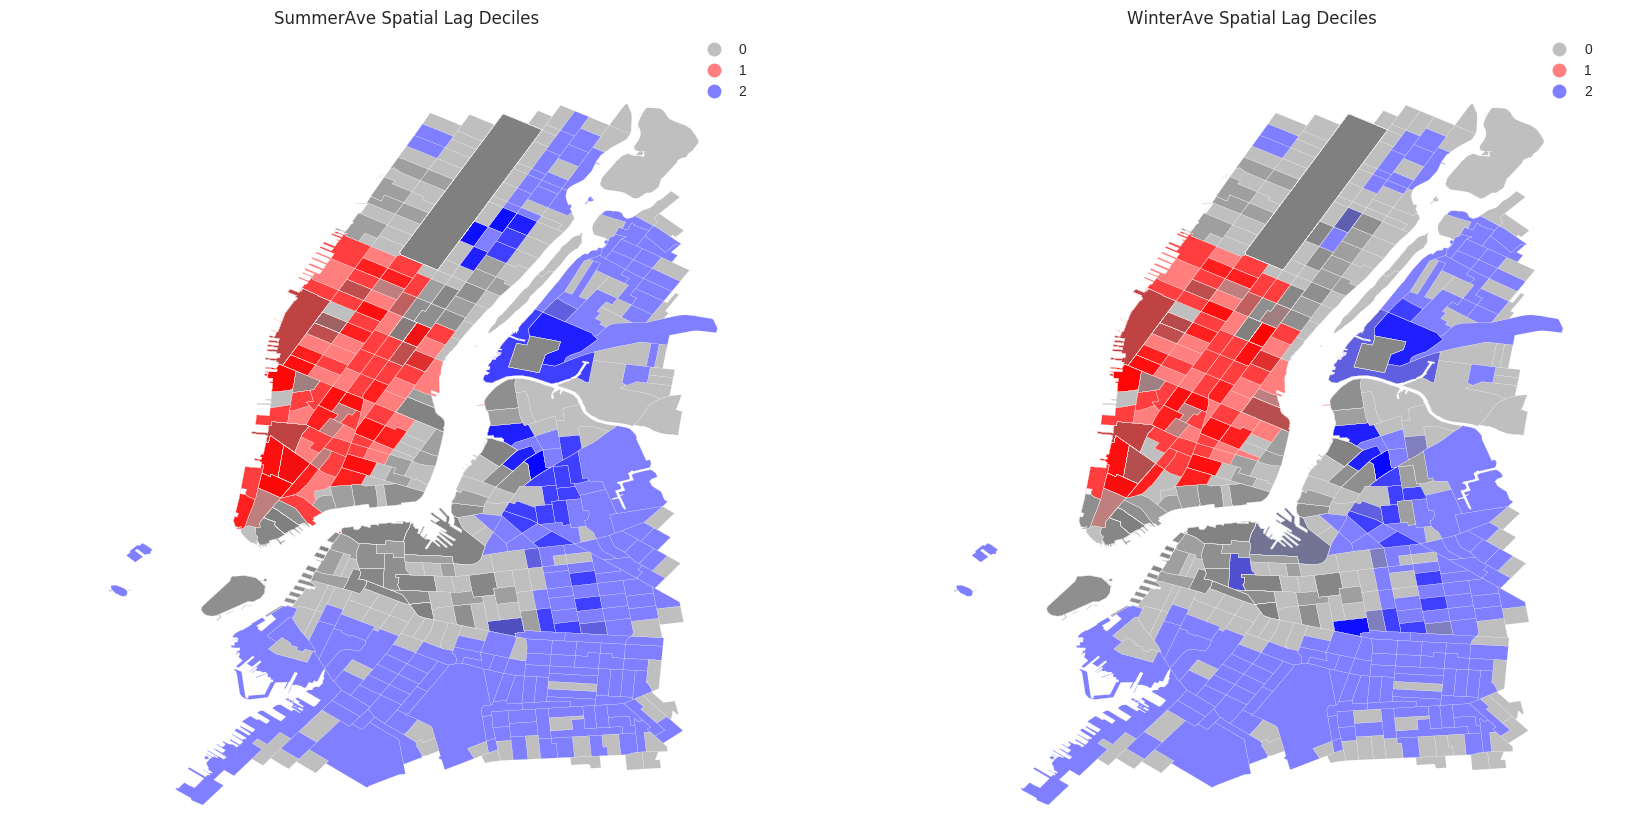

In [117]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey','red','blue'])

Summer_hotcold = Summer_hotspots*1 + Summer_coldspots*2
Winter_hotcold = Winter_hotspots*1 + Winter_coldspots*2

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ct_shape_SummerAve_Zoom.assign(cl=Summer_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax1.set_title("SummerAve Spatial Lag Deciles")

ct_shape_WinterAve_Zoom.assign(cl=Winter_hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("WinterAve Spatial Lag Deciles")

### Figure 12: Hot Spot and Cold Spot plo